### E-commerce Campaign Analysis

In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=68ed2ec9eba0eb4fd57d72a5096cc01756d0998eea7043958351e6f7ff9a9fbd
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [4]:
!pip install findspark
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.10/dist-packages/pyspark'

In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

##DATA SETUP

In [6]:
sc = SparkContext(appName="E commerce Annalysis")
sqlc = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
data_file = 'Dataset.csv'

In [8]:
data = sqlc.read.csv(data_file,header = True)

## DATA EXPLORATION

In [9]:
data.count()

29

In [10]:
data.dtypes

[('reg no', 'string'),
 ('Form no', 'string'),
 ('Rate', 'string'),
 ('Review', 'string'),
 ('message', 'string'),
 ('spam msg', 'string')]

In [ ]:
data.limit(3).toPandas()

,reg no,Form no,Rate,Review,message,spam msg
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive


In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = (
    SparkSession
    .builder
    .appName("ecommerce")
    .master("local[*]")
    .getOrCreate()
)

In [ ]:
holidays_path = "holidays.csv"
campaigns_path = "campaigns.csv"

holidays = spark.read.csv(holidays_path, inferSchema = True, header=True)
campaigns = spark.read.csv(campaigns_path, inferSchema = True, header=True)

In [ ]:
print("Campaign Schema")
campaigns.printSchema()

Campaign Schema
root
 |-- id: integer (nullable = true)
 |-- campaign_type: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- finished_at: timestamp (nullable = true)
 |-- total_count: integer (nullable = true)
 |-- ab_test: boolean (nullable = true)
 |-- warmup_mode: boolean (nullable = true)
 |-- hour_limit: integer (nullable = true)
 |-- subject_length: double (nullable = true)
 |-- subject_with_personalization: boolean (nullable = true)
 |-- subject_with_deadline: boolean (nullable = true)
 |-- subject_with_emoji: boolean (nullable = true)
 |-- subject_with_bonuses: boolean (nullable = true)
 |-- subject_with_discount: boolean (nullable = true)
 |-- subject_with_saleout: boolean (nullable = true)
 |-- is_test: boolean (nullable = true)
 |-- position: integer (nullable = true)



In [ ]:
print("holidays Schema")
holidays.printSchema()

holidays Schema
root
 |-- date: date (nullable = true)
 |-- holiday: string (nullable = true)



In [ ]:

print("Using campaign_type+id as unique identifier: (filter key that count isn't 1)")
campaign_withUniqueIdenti = (
    campaigns
    .withColumn("campaign_id", F.concat(F.col("campaign_type"),F.col("id")))
)
(
    campaign_withUniqueIdenti
    .groupBy("campaign_id")
    .count()
    .filter(F.col("count") != 1)
).show()

Using campaign_type+id as unique identifier: (filter key that count isn't 1)
+-----------+-----+
|campaign_id|count|
+-----------+-----+
+-----------+-----+



In [ ]:
print("From data1.csv")
(
    campaigns
    .select("campaign_type")
    .distinct()
).show()

From data1.csv
+-------------+
|campaign_type|
+-------------+
|         bulk|
|      trigger|
|transactional|
+-------------+



In [ ]:
campaignData = (
    campaign_withUniqueIdenti
    .select("campaign_id","channel","topic","started_at","finished_at","total_count")
)
(
    campaignData
    .orderBy(F.desc(F.col("total_count")))
).show(truncate = False)

+-----------+-------+--------+--------------------------+-------------------+-----------+
|campaign_id|channel|topic   |started_at                |finished_at        |total_count|
+-----------+-------+--------+--------------------------+-------------------+-----------+
|bulk4918   |email  |sale out|2022-06-15 06:30:07.193285|2022-06-15 09:38:54|5371769    |
|bulk1961   |email  |sale out|2021-11-23 07:22:46.753197|null               |5366976    |
|bulk2003   |email  |sale out|2021-11-24 07:03:20.136238|2021-11-24 14:31:56|5327892    |
|bulk9110   |email  |sale out|2022-12-30 07:00:11.67307 |2022-12-30 10:54:27|5251007    |
|bulk2499   |email  |sale out|2022-01-03 07:00:11.774563|2022-01-03 11:19:05|5186414    |
|bulk4679   |email  |sale out|2022-06-01 08:22:32.520607|2022-06-01 15:50:43|5110574    |
|bulk4744   |email  |sale out|2022-06-04 11:18:39.563776|2022-06-04 14:00:21|5036440    |
|bulk8252   |email  |sale out|2022-11-30 06:51:11.67617 |2022-11-30 11:04:51|4957576    |
|bulk7879 

Missing Values:
data.no             0
volatile            0
quantity            0
residual product    0
weight p/kg         0
free gifts          0
total products      0
density             0
alcoho content      0
quality             0
dtype: int64
Sum of Missing Values:
0
Number of Zeros: 132
Accuracy of Decision Tree: 0.596875
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.07      0.10      0.08        10
           5       0.70      0.66      0.68       130
           6       0.62      0.61      0.61       132
           7       0.50      0.57      0.53        42
           8       0.00      0.00      0.00         5

    accuracy                           0.60       320
   macro avg       0.32      0.32      0.32       320
weighted avg       0.61      0.60      0.60       320

Confusion Matrix:
[[ 0  0  1  0  0  0]
 [ 1  1  5  3  0  0]
 [ 0  6 86 31  6  1]
 [ 0  6 27 80 16  3]
 

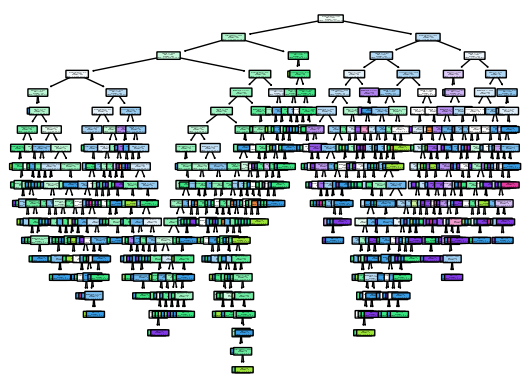

Accuracy of Random Forest: 0.675
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.72      0.78      0.75       130
           6       0.66      0.72      0.69       132
           7       0.59      0.48      0.53        42
           8       0.00      0.00      0.00         5

    accuracy                           0.68       320
   macro avg       0.33      0.33      0.33       320
weighted avg       0.64      0.68      0.66       320

Confusion Matrix:
[[  0   0   1   0   0   0]
 [  1   0   7   2   0   0]
 [  0   0 101  27   2   0]
 [  0   0  28  95   9   0]
 [  0   0   3  18  20   1]
 [  0   0   0   2   3   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pydotplus
from six import StringIO

# Load the dataset
df = pd.read_csv('product.csv')


# Display missing values and sum of missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)
print("Sum of Missing Values:")
print(missing_values.sum())

# Count the number of zeros in the dataset
zero_count = (df == 0).sum().sum()
print("Number of Zeros:", zero_count)

# Select the features and target variable
X = df.drop('quality', axis=1)
y = df['quality']

# Replace zeros with NaN
X = X.replace(0, np.nan)

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
decision_tree.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = decision_tree.predict(X_test)

# Calculate the accuracy of the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy of Decision Tree: {accuracy_dt}")

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Visualize the Decision Tree
dot_data = StringIO()
plot_tree(decision_tree, feature_names=df.columns[:-1], class_names=str(decision_tree.classes_), filled=True, rounded=True)
plt.show()
#print("\ninga paaru \n",decision_tree.classes_)
# Create a Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
random_forest.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = random_forest.predict(X_test)

# Calculate the accuracy of the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest: {accuracy_rf}")

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

## Data Visualitation

In [ ]:
!pip install matplotlib


/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


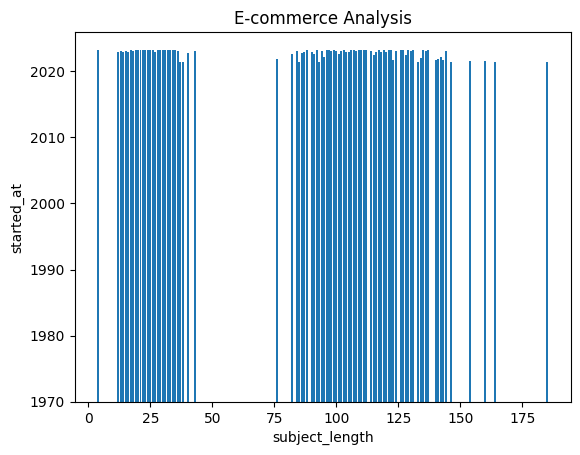

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read data from a CSV file into a DataFrame
df = spark.read.csv('campaigns.csv', header=True, inferSchema=True)

# Perform necessary data transformations or filtering
# For example, let's select two columns for the bar plot
selected_df = df.select('subject_length', 'started_at')

# Convert the DataFrame to Pandas DataFrame for plotting
pandas_df = selected_df.toPandas()

# Plot the data using matplotlib
plt.bar(pandas_df['subject_length'], pandas_df['started_at'])

# Set labels and title
plt.xlabel('subject_length')
plt.ylabel('started_at')
plt.title('E-commerce Analysis')

# Display the plot
plt.show()